## Store Sales - Time Series Forecasting

### **Descriptions**

**train.csv:**
* store_nbr =  identifies the store at which the products are sold.
* family =  identifies the type of product sold.
* sales = total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* onpromotion = the total number of items in a product family that were being promoted at a store at a given date.

**test.csv:**
* Same features as the training data. The target sales for the dates in this files.
* The dates in the test are for the 15 days after the last date in the training data.

**stores.csv**

* Store metadata: city, state, type and cluster.
* Cluster is a grouping of similar stores.

**oil.csv**

* Daily oil price. Include values during both the train and test data timeframes.
* Ecuador is an oil-dependent country and it´s economical health is highly bulnerable to shocks in oil prices.


**Holidays_events.csv**

* Holidays and events, with metadata.
* Transferred column: A transferred day is more like a normal day than a holiday.

**Additional Notes**
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this. (Seasonality?)
* A magnitude 7.8 earthquake struck Ecuador on `April 16, 2016`. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [684]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import mean_squared_error as MSE

### 1st Part: **EDA**

In [685]:
# Paths
train_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\train.csv"
test_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\test.csv"
stores_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\stores.csv"
oil_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\oil.csv"
transactions_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\transactions.csv"
holidays_events_pth = r"C:\Users\willi\OneDrive\Documentos\5. Estudos\Kaggle_Notebooks\Store_Sales\data\holidays_events.csv"

<p style="text-align: justify"> When we see to this dataset, we see that columns dates are deconfigured. One option to solve this is to focus the feature values ​​around the day of the date column. Let's see how we can do this.</p>

In [802]:
# Importing Datasets
train = pd.read_csv(train_pth)
test = pd.read_csv(test_pth)
stores = pd.read_csv(stores_pth)
oil = pd.read_csv(oil_pth)
events = pd.read_csv(holidays_events_pth, parse_dates=['date'])
transactions = pd.read_csv(transactions_pth)

In [687]:
# <p style="text-align: justify">XXXXXXX</p>

### **File:** stores.csv
<p style="text-align: justify">Let's start with stores.csv! We can see that the data of "stores.csv" is only to give us some information about the stores, like location, cluster and others.</p>

In [688]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### **File:** oil.csv
<p style="text-align: justify">The file about oil consume (oil.csv) is very interesting!! Let's see if we find duplicate data in the date column.</p>

In [689]:
print('The column date has only single values?\n', oil.date.is_unique) # Check if values are unique. OK!!!

The column date has only single values?
 True


### **File:** holidays_events.csv
<p style="text-align: justify">The Events file has a date columns. If we check this column we will see duplicates values.  </p>

In [690]:
print('The column date has only single values?\n', events.date.is_unique) #  The values are not unique.

The column date has only single values?
 False


<p style="text-align: justify">So, we need to find an solution to solve this. Firstly, It's observed that all columns in events.csv are categorical (object). So, this information is very important. It's also noticed that de Column "date" insted of a DateTime object.</p>

In [691]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


<p style="text-align: justify">If we look carefully, It's possible to check which dates are duplicated.</p>

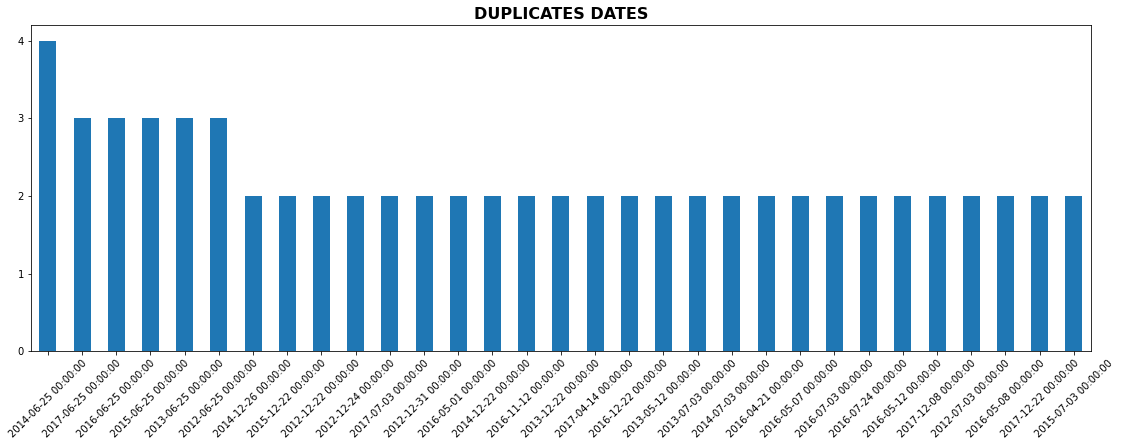

In [692]:
df_event_dupl = pd.DataFrame(events.date.value_counts())
df_event_dupl.rename(columns={'date':'values'})
df_event_dupl[df_event_dupl>=2].dropna().plot(kind='bar', figsize=(19,6), legend=None)
plt.xticks(rotation=45)
plt.yticks(np.arange(0,5))
plt.title("DUPLICATES DATES", fontweight="bold", fontsize=16)
plt.show()

In [693]:
events[events.date=="2014-06-25"] # See!! There are duplicated values.

,date,type,locale,locale_name,description,transferred
110,2014-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
111,2014-06-25,Holiday,Local,Machala,Fundacion de Machala,False
112,2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False


<p style="text-align: justify">So, we will deal with this by aggregating values ​​related to the same date.  </p>

In [694]:
event_cat_col = [c for c in events.columns if events[c].dtypes=='O'] # Separating Categoricals Columns
events.set_index('date')
from feature_engine.encoding import OneHotEncoder
ohe = OneHotEncoder(variables=event_cat_col)
events = ohe.fit_transform(events)
col_event = events.iloc[:,1:].columns.to_list()
events = events.groupby('date')[col_event].sum()

C:\Users\willi\AppData\Local\Programs\Python\Python39\lib\site-packages\feature_engine\encoding\one_hot.py:276: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


In [697]:
events[events.index=="2014-06-25"] # See!! No more duplicated values.

,transferred,type_Holiday,type_Transfer,type_Additional,type_Bridge,type_Work Day,type_Event,locale_Local,locale_Regional,locale_National,...,description_Terremoto Manabi+28,description_Terremoto Manabi+29,description_Terremoto Manabi+30,description_Traslado Batalla de Pichincha,description_Traslado Fundacion de Guayaquil,description_Traslado Primer Grito de Independencia,description_Puente Dia de Difuntos,description_Recupero Puente Dia de Difuntos,description_Traslado Primer dia del ano,description_Traslado Fundacion de Quito
date,,,,,,,,,,,,,,,,,,,,,
2014-06-25,0,3,0,0,0,0,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0


### **File:** transactions.csv
<p style="text-align: justify">This file contains 3 (three) columns: date, store_nbr (like as the train.csv file) and transaction's column. Let's see if there are duplicates valoes in this date column.</p>

In [701]:
print('The column date has only single values?\n', transactions.date.is_unique) #  The values are not unique.

The column date has only single values?
 False


<p style="text-align: justify">There are a lot of transactions by stores and by date. So we will divide them in TRANSACTIONS - DATE and TRANSACTION - STORE.</p>

In [714]:
transactions_store = transactions.groupby('store_nbr')['transactions'].sum()
transactions_date = transactions.groupby('date')['transactions'].sum()

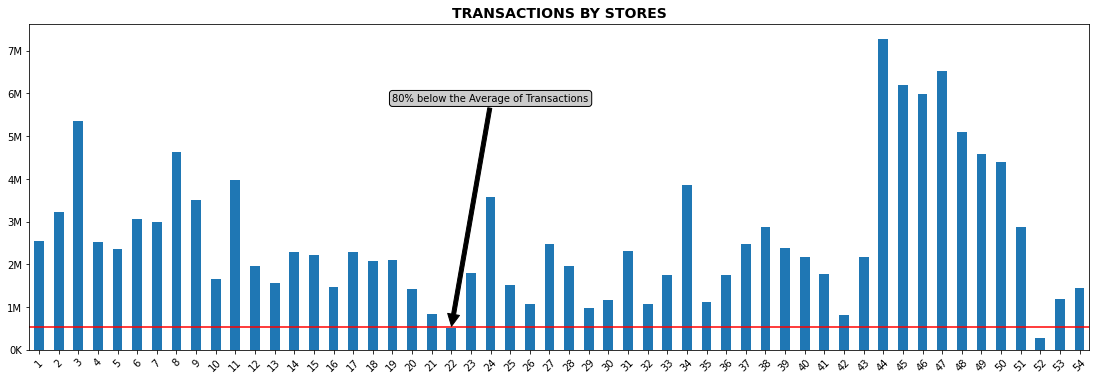

In [799]:
def values(x, pos):
    """The two arguments are the value and tick position"""
    if x >= 1e6:
        s = '{:1.0f}M'.format(x*1e-6)
    else:
        s = '{:1.0f}K'.format(x*1e-3)
    return s
percent = 80
threshold =  transactions.transactions.sum()/len(transactions.store_nbr.unique()) * ((100 - percent)/100)
fig, ax = plt.subplots(figsize= (19,6))
transactions_store.dropna().plot(kind='bar',legend=None)
plt.xticks(rotation=45)
ax.set_title("TRANSACTIONS BY STORES", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
ax.axhline(y=threshold, color='red')
ax.annotate(f'{ percent:.0f}% below the Average of Transactions', xy=(21, threshold), xytext=(23, 6000000),bbox=dict(boxstyle="round", fc="0.8"), arrowprops=dict(facecolor='black', shrink=0.005),horizontalalignment='center', verticalalignment='top')
plt.show()

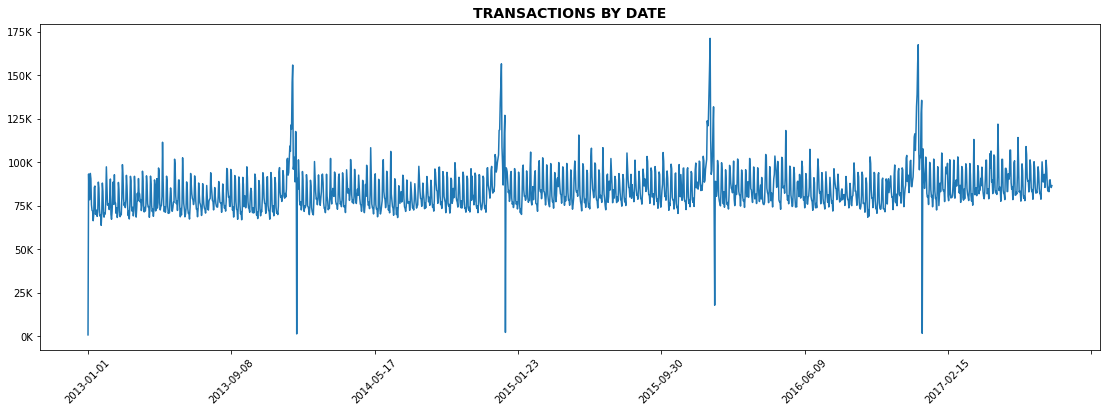

In [722]:
fig, ax = plt.subplots(figsize= (19,6))
transactions_date.dropna().plot(legend=None)
plt.xticks(rotation=45)
ax.set_title("TRANSACTIONS BY DATE", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

### **File:** train.csv
<p style="text-align: justify">This file contains 4 (four) columns: id (In this case, it's irrelevant!), date, store_nbr, family, sales (target variable) and onpromotion. Here, I will make some observations that I think are important for us to think about the training set.</p>
<p style="text-align: justify"> The family variable has categorical values, in my opinion, which are relevant to be analyzed in separate columns can add value to the calculations. However, when we go to test our model in the test suite, this column will not be separated.</p>

<p style="text-align: justify">The influences of the promotion column on the family, store and data columns. Is there a strong relationship?
We could use Person Correlation to perform these evaluations. Personally, I prefer bar charts for better visualization. However, I will put an example of Person Correlation.</p>

<p style="text-align: justify">About store data (store.csv), we can merge with store data (train.csv). We can even create a column to list stores located in cities where events took place.</p>

Let's go?

In [800]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [806]:
# Merge train -  stores - transactions
df = pd.merge(train,stores,on='store_nbr')
df.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [ ]:
df.groupby

In [807]:
fig, ax = plt.subplots(figsize= (19,6))
transactions_date.dropna().plot(legend=None)
plt.xticks(rotation=45)
ax.set_title("TRANSACTIONS BY DATE", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

(3000888, 10)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [ ]:
# Datasets
train = pd.read_csv(train_pth)
stores = pd.read_csv(stores_pth)
oil = pd.read_csv(oil_pth)
events = pd.read_csv(holidays_events_pth)
transactions = pd.read_csv(transactions_pth)

# Merge train -  stores - transactions
df = pd.merge(train,stores,on='store_nbr')
df = pd.merge_ordered(df, transactions, on=['date', 'store_nbr'])

# Merge DataFrame - Events
df = pd.merge(df, events, on=['date'], how='outer')

# Merge Dataframe - Oil
df = pd.merge(df, oil, on=['date'], how='outer')

df.drop('id', axis=1, inplace=True)

# Filling NaN with zeros
df.fillna(0, inplace=True)

# Rename Columns
df.rename(columns={'type_x':'type_store', 'type_y':'type_day'}, inplace=True)

# Extracting Days of Week
df['date'] = pd.to_datetime(df['date'])
df['day_week_name'] = df['date'].dt.dayofweek
df['is_weekend'] = np.where(df['day_week_name'].isin([6,5]), "Weekend", "Work_day")

# Drop zeros in Sales Columns
df = df[df['sales'] != 0]

In [ ]:
# Check null values
df.isnull().sum()

date             0
store_nbr        0
family           0
sales            0
onpromotion      0
city             0
state            0
type_store       0
cluster          0
transactions     0
type_day         0
locale           0
locale_name      0
description      0
transferred      0
dcoilwtico       0
day_week_name    0
is_weekend       0
dtype: int64

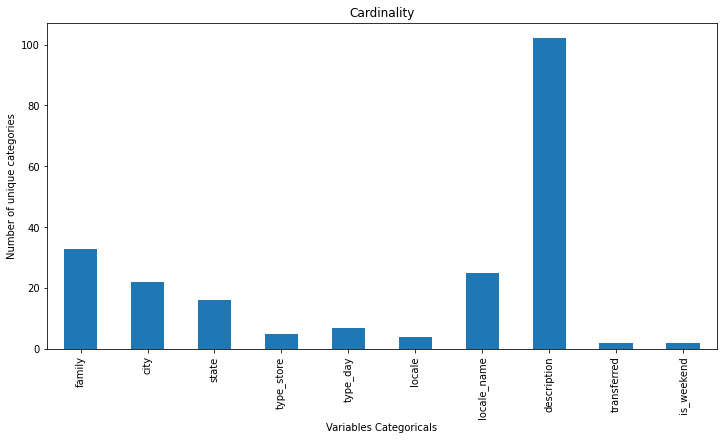

In [ ]:
# Plot with the cardinality of each variable
df[[c for c in df.columns if df[c].dtypes=='O']].nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables Categoricals')
plt.title('Cardinality')
plt.show()

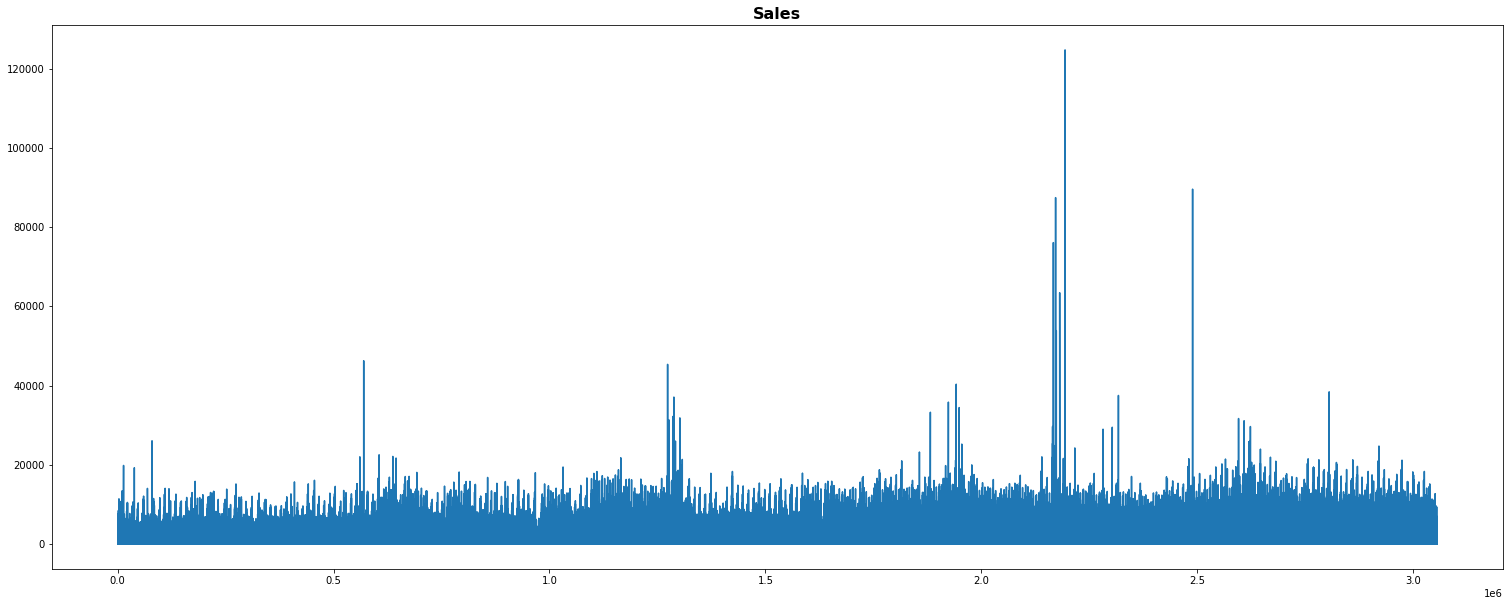

In [ ]:
# Plotting Sales
plt.figure(figsize=(26,10))
plt.plot(df.sales)
plt.title("Sales", fontweight="bold", fontsize=16)
plt.show()

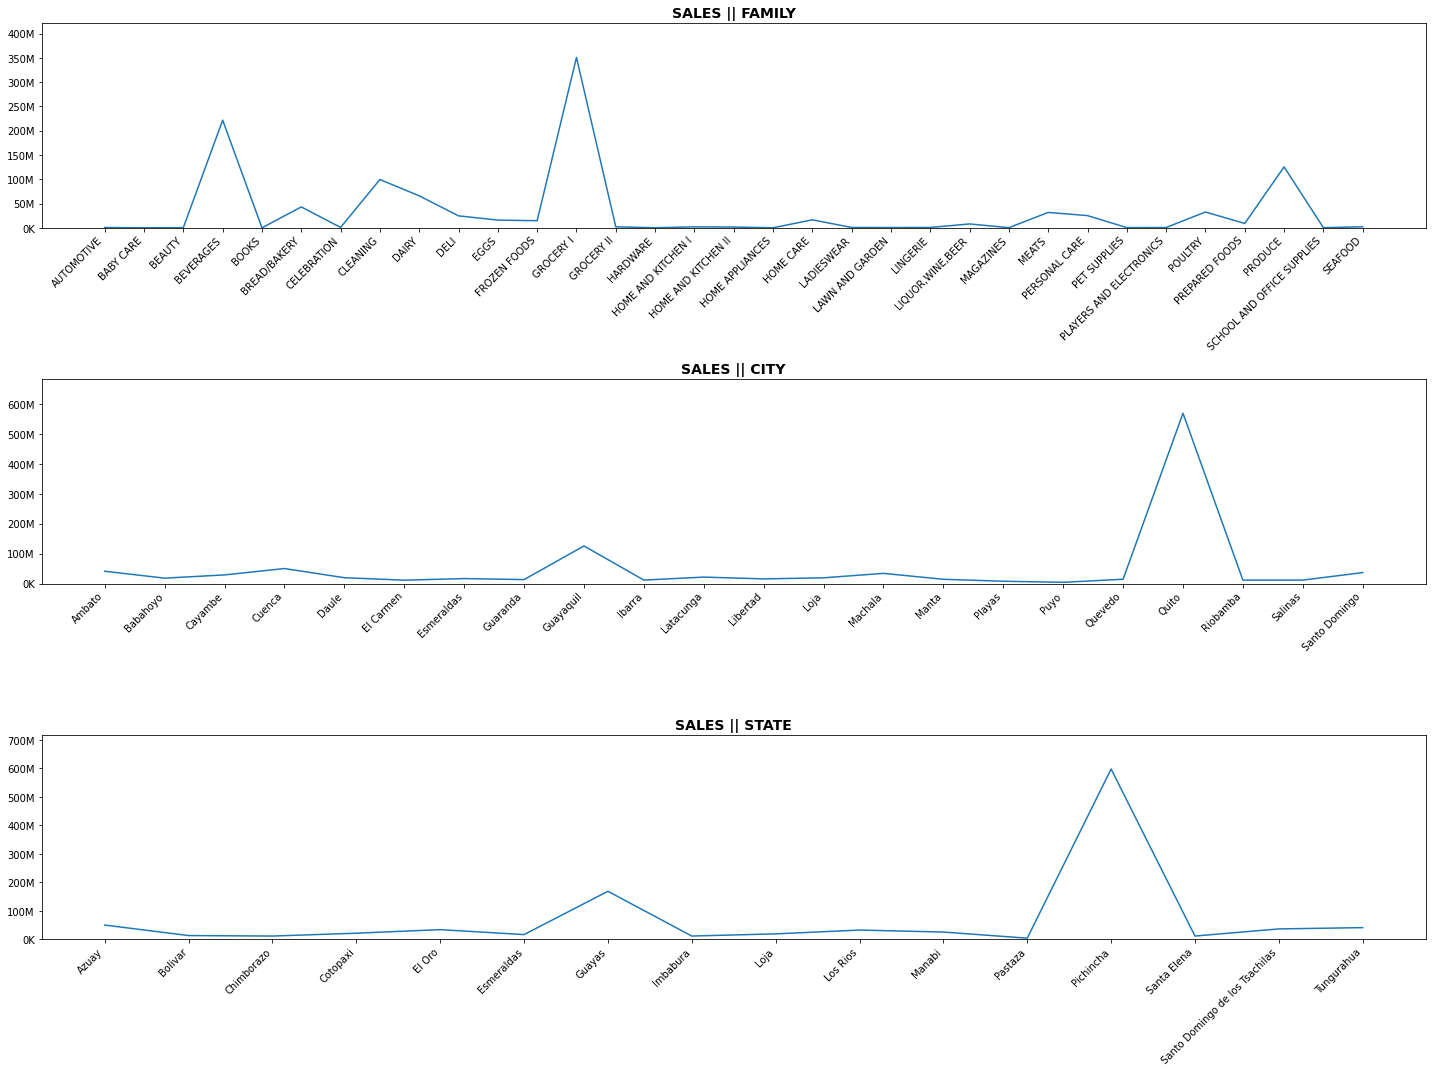

In [ ]:
# Plotting others Features
features = ['family', 'city', 'state']

def values(x, pos):
    """The two arguments are the value and tick position"""
    if x >= 1e6:
        s = '{:1.0f}M'.format(x*1e-6)
    else:
        s = '{:1.0f}K'.format(x*1e-3)
    return s

fig, ax = plt.subplots(len(features),1, figsize=(20, (5*len(features))))

for i, feature in enumerate(features):
	if df[feature].name in df.select_dtypes(include='object').columns:
	# Max Values Sales
		max_values = df.groupby([feature])['sales'].sum().max() *1.2
		ax[i].plot(df.groupby([feature])['sales'].sum())

	# Set Title
		ax[i].set_title(f"SALES || {feature.upper()}", fontweight="bold", fontsize=14)


	# Configure xticks
		labels = ax[i].get_xticklabels()
		plt.setp(labels, rotation=45, horizontalalignment='right')

	# Configure yticks
		ax[i].yaxis.set_major_formatter(values)
		ax[i].set(ylim=[0,max_values])

fig.tight_layout()
plt.show()

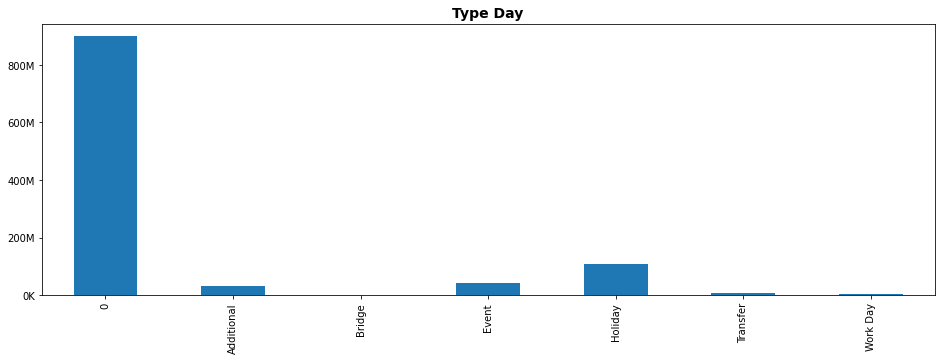

In [ ]:
fig, ax = plt.subplots(figsize= (16,5))
df.groupby('type_day')['sales'].sum().plot(kind='bar')
ax.set_title("Type Day", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

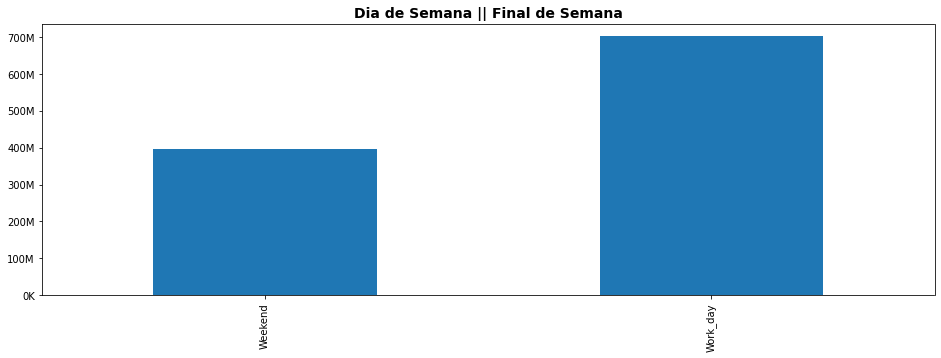

In [ ]:
fig, ax = plt.subplots(figsize= (16,5))
df.groupby('is_weekend')['sales'].sum().plot(kind='bar')
ax.set_title("Dia de Semana || Final de Semana", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

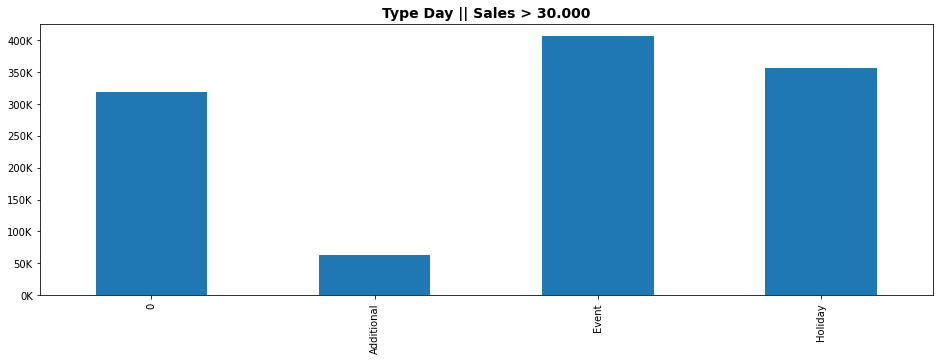

In [ ]:
df_maior_300k = df[df.sales > 30000]
fig, ax = plt.subplots(figsize= (16,5))
df_maior_300k.groupby('type_day')['sales'].sum().plot(kind='bar')
ax.set_title("Type Day || Sales > 30.000", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

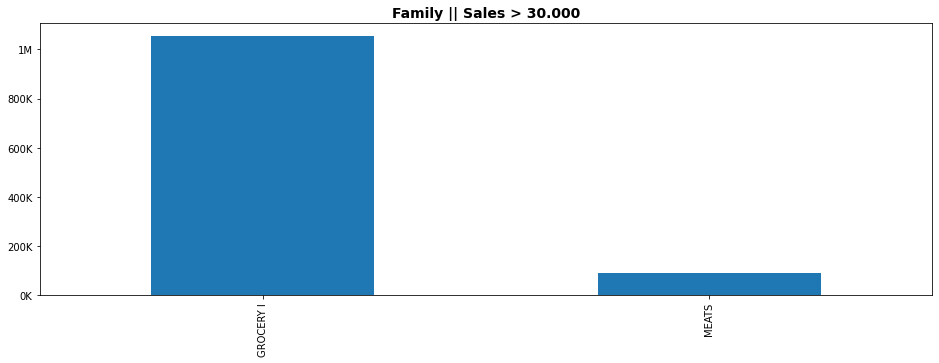

In [ ]:
df_maior_300k = df[df.sales > 30000]
fig, ax = plt.subplots(figsize= (16,5))
df_maior_300k.groupby('family')['sales'].sum().plot(kind='bar')
ax.set_title("Family || Sales > 30.000", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

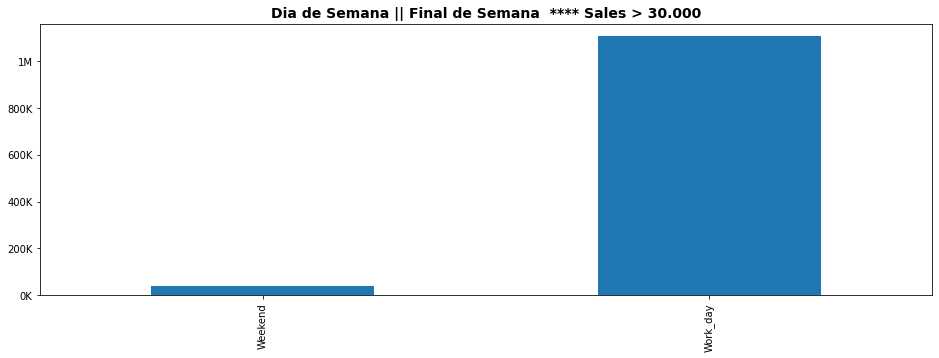

In [ ]:
fig, ax = plt.subplots(figsize= (16,5))
df_maior_300k.groupby('is_weekend')['sales'].sum().plot(kind='bar')
ax.set_title("Dia de Semana || Final de Semana  **** Sales > 30.000", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

### 2nd Part: **Analysing the Time Series**


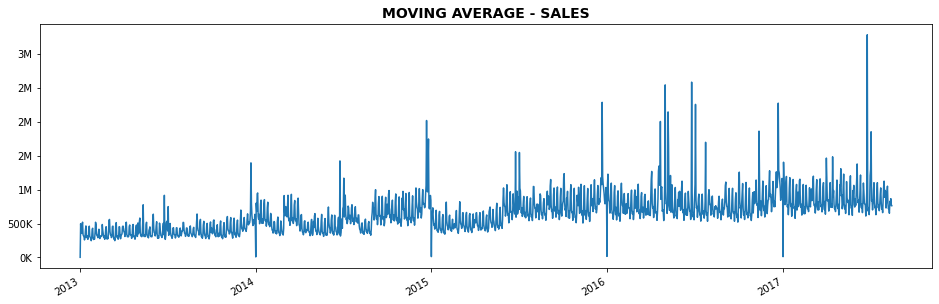

In [ ]:
## Moving Average
fig, ax = plt.subplots(figsize= (16,5))
df.groupby('date')['sales'].sum().plot()
ax.set_title("MOVING AVERAGE - SALES", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(values)
plt.show()

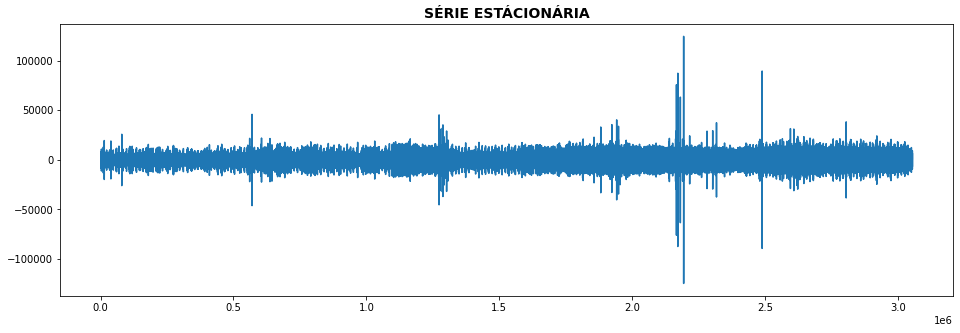

In [ ]:
fig, ax = plt.subplots(figsize= (16,5))
df.sales.diff(1).plot()
ax.set_title("SÉRIE ESTÁCIONÁRIA", fontweight="bold", fontsize=14)
ax.set_xlabel(None)
plt.show()

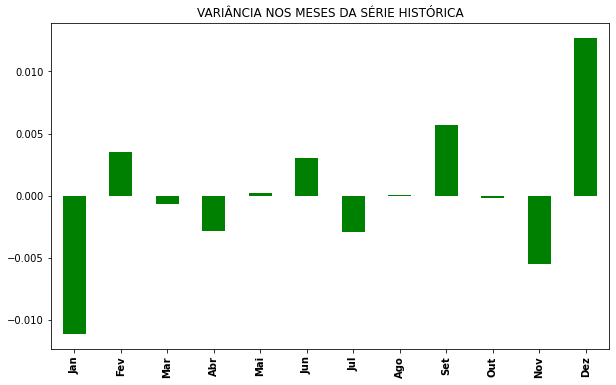

In [ ]:
# Variância nos Meses da Série Histórica
df.sales.diff(1).groupby(df.date.dt.month).mean().plot(kind='bar', figsize=(10, 6), cmap='ocean')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'], fontweight='bold')
plt.title("VARIÂNCIA NOS MESES DA SÉRIE HISTÓRICA")
plt.xlabel(None)
plt.show()

<div style="text-align: justify"> Analisando o gráfico acima, o mês de JANEIRO possui as maiores quedas em termos de vendas. Já o mês de DEZEMBRO já aponta para uma época onde as vendas estão em alta. Ao londo dos meses percebemos que ocorrem variações entre altas e baixas.</div>

### 3rd Part: **Preparation**

In [ ]:
# Separating Features and Target
X = df.drop(labels=['sales'], axis=1)
y = df['sales']

In [ ]:
# Make lists with categorical and numerical variables:
cat_cols = [c for c in df.columns if df[c].dtypes=='O']
num_cols = [c for c in df.columns if df[c].dtypes!='O']

In [ ]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder()
X_cat_encod = encoder.fit_transform(X[cat_cols])
X_num_col = X.drop(labels=cat_cols + ['day_week_name'], axis=1)

# New DataFrame 
df_encod = pd.concat([X_num_col,X_cat_encod], axis=1)

C:\Users\willi\AppData\Local\Programs\Python\Python39\lib\site-packages\feature_engine\encoding\one_hot.py:276: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


In [ ]:
# Total Lines
lines = df_encod.shape[0]
print(f'DataFrame has {lines:1,d} lines.')

# Train - Test values
train_values = int(lines * 0.7)

X_train = X[:train_values]
y_train = X[train_values:]

X_test = y[:train_values]
y_test = y[train_values:]

DataFrame has 2,100,607 lines.


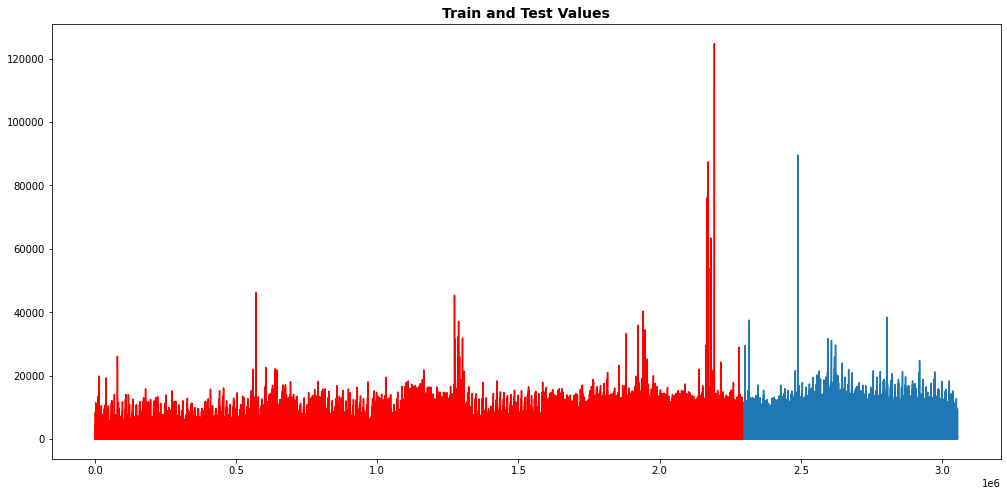

In [ ]:
# Plotting Train and Test Values
plt.figure(figsize=(17,8))
plt.plot(X_train.index,X_test,c='red')
plt.plot(y_train.index,y_test)
plt.title("Train and Test Values", fontweight="bold", fontsize=14)
plt.show()

#### **Naive Method**

In [ ]:
df.

SyntaxError: invalid syntax (Temp/ipykernel_6988/791285630.py, line 1)

In [ ]:
# Creating a Column - Naive_Prediction
df['naive_prediction'] = df.sales.shift(1)

In [ ]:
df.head()

,store_nbr,family,sales,onpromotion,city,state,type_store,cluster,transactions,type_day,locale,locale_name,description,transferred,dcoilwtico,day_week_name,is_weekend,naive_prediction
date,,,,,,,,,,,,,,,,,,
2013-01-01,25.0,BEAUTY,2.000,0.0,Salinas,Santa Elena,D,1.0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,0.0,1,Work_day,NaN
2013-01-01,25.0,BEVERAGES,810.000,0.0,Salinas,Santa Elena,D,1.0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,0.0,1,Work_day,2.000
2013-01-01,25.0,BREAD/BAKERY,180.589,0.0,Salinas,Santa Elena,D,1.0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,0.0,1,Work_day,810.000
2013-01-01,25.0,CLEANING,186.000,0.0,Salinas,Santa Elena,D,1.0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,0.0,1,Work_day,180.589
2013-01-01,25.0,DAIRY,143.000,0.0,Salinas,Santa Elena,D,1.0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,0.0,1,Work_day,186.000
